In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

from matplotlib import colors

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject 

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

import sys
import os

%load_ext autoreload
%autoreload 2

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools

In [2]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# roi_2
roi_name = 'roi_2'


# /roi_2

In [3]:
# locations = pd.read_csv(f'{filepath}{roi_name}/exports/cell_attributes_cell_10px_20240605.csv',index_col=0)
# matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240606_10px_cell.csv',index_col=0)

# matrix.set_index(matrix.index.astype(str),inplace=True)
# locations.set_index(matrix.index.astype(str),inplace=True)

# /Volumes/GRK_001/spatialbarcodes/2024-05-21_mouseexp_expression/projects/roi2/exports/
with open(f'{filepath}{roi_name}/exports/sg_object_20240604_dilate10.pkl', 'rb') as f:
    sg_obj = pickle.load(f)


In [4]:
# set object id (as string) as index

matrix = sg_obj.get_cell_gene_table_df()
matrix['object_id'] = [str(int(x)) for x in matrix['object_id']]
matrix.set_index('object_id',inplace=True)

sg_obj.gdf['object_id'] = [str(int(x)) for x in sg_obj.gdf['object_id']]
sg_obj.gdf.set_index('object_id',inplace=True)

No filtering available or applied.


In [5]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values
sg_obj.gdf['center_x'] = sg_obj.gdf['nucleus'].centroid.x.values
sg_obj.gdf['center_y'] = sg_obj.gdf['nucleus'].centroid.y.values
sg_obj.gdf['area'] = sg_obj.gdf['nucleus_dilated'].area.values

In [6]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

In [7]:
cutoff = 4

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
# df.set_index('object_id')

df = matrix

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


In [8]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

In [9]:
adata_genes = sc.AnnData(df[gene_cols])

cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]

In [10]:
min_area = 2000

adata_genes = adata_genes[adata_genes.obs['area']>min_area]

In [11]:
# filter cells and genes by number of occurences 
sc.pp.filter_cells(adata_genes, min_genes=15) # keep only cells that have at least 10 genes
sc.pp.filter_genes(adata_genes, min_cells=500) # keep only genes that are expressed in at least 500 cells

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [12]:
total_bc_threshold = 10

# include cells with at least 10 barcode spots
has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
matrix = has_bcs[barcode_cols]

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

In [13]:
threshold = 0.4
cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)

In [14]:
cluster_name_cutoff = 3


obj_clusters = {obj_id:clus for obj_id,clus in zip(matrix.index,cluster.labels_)}

cluster_objects = {}
cluster_barcode_names = {}
cluster_found_barcodes = {}
cluster_n_found_barcodes = {}

for clu in np.unique(cluster.labels_):
    cluster_objects[clu] = matrix.index[cluster.labels_ == clu]

    avg_bc_counts = np.mean(matrix[cluster.labels_ == clu],axis=0)
    # print(avg_bc_counts)
    # break

    found_bcs = []

    for bc in barcode_cols:
        if avg_bc_counts[bc] > cutoff:
            found_bcs.append(bc)

    print(clu,found_bcs)

    cluster_found_barcodes[clu] = found_bcs
    cluster_n_found_barcodes[clu] = len(found_bcs)

    cluster_barcode_names[clu] = '-'.join(sorted(found_bcs))

0 ['bc_091']
1 []
2 ['bc_063', 'bc_066']
3 ['bc_094']
4 []
5 ['bc_003', 'bc_009']
6 ['bc_094']
7 ['bc_001', 'bc_031', 'bc_033', 'bc_087']
8 ['bc_007', 'bc_013', 'bc_054', 'bc_060']
9 ['bc_006', 'bc_018', 'bc_043']
10 ['bc_021', 'bc_049', 'bc_079']
11 ['bc_019', 'bc_025', 'bc_074', 'bc_092']
12 ['bc_074', 'bc_083']
13 ['bc_008', 'bc_040']
14 []
15 ['bc_001', 'bc_024', 'bc_029', 'bc_031', 'bc_066', 'bc_087', 'bc_091']
16 ['bc_040', 'bc_052', 'bc_092', 'bc_093']
17 ['bc_030', 'bc_060']
18 ['bc_060']
19 ['bc_022', 'bc_087']
20 ['bc_026', 'bc_041']
21 ['bc_021', 'bc_028', 'bc_060', 'bc_067', 'bc_074']
22 ['bc_003', 'bc_009', 'bc_066', 'bc_087']
23 ['bc_085']
24 ['bc_024', 'bc_025', 'bc_041']
25 ['bc_031', 'bc_047', 'bc_093']
26 ['bc_008', 'bc_035', 'bc_059', 'bc_063', 'bc_074', 'bc_081']
27 ['bc_066', 'bc_091']
28 ['bc_008', 'bc_041', 'bc_096']
29 ['bc_016']
30 ['bc_002', 'bc_060']
31 ['bc_025', 'bc_079', 'bc_083']
32 ['bc_028', 'bc_092']
33 ['bc_048']
34 ['bc_060']
35 ['bc_049', 'bc_079']


In [204]:
adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_found_bcs'] = [cluster_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_bc_names'] = [cluster_barcode_names[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]

In [16]:


triple_bc_clusters = adata_genes.obs[adata_genes.obs['bc_cluster_n_bcs'] >= 3]    

cs,counts = np.unique([int(x) for x in triple_bc_clusters['bc_cluster'].values],return_counts=True)

cs[np.argsort(counts)[::-1]]

array([ 311,  372,   91, 1214,   39, 1096,  512,  238, 1114,  644,   31,
        277, 1101,  256,  332,    8,  258,   71,   72,   78,   42,  161,
         92, 1394,   26,  100,  208,  448,  157,  412,  109,   97,  910,
        746,  617, 1020,  538,   55,  965,   28,  564,  176,  756,  195,
         16, 1534,  186,  753,  927,  356,   10, 3176,   49,  481,  155,
        846, 1510,  511,  431,  228,  250,   57, 1408,  396, 1080,  894,
       1254,  651,  684, 1590,  175, 1383,  335,  632, 1315,  863,  539,
        381,  622,   22,  204,  213,  338,  321, 1511, 1522,  344, 1190,
        196,  279,  331,   93,  527,  318,  339,  329,  325,  599,  247,
        300,  255, 1677,  888,  411,  795,  293,  652, 1692, 1442,  394,
        748,  818,   47, 1666,  620,  112,  567,   83,   41,  783,  605,
        222,  438,  371,  467,  454, 1401, 1072,  446, 1820,  981,  407,
       1228, 1148, 2616,  360, 1112,  319, 1404,  309,  232,  167,  340,
        525, 1646,  551, 1658,  127,  889, 1561,  8

In [17]:
clusters_to_show = []

for clu,count in zip(cs[np.argsort(counts)[::-1]],counts[np.argsort(counts)[::-1]]):
    if count > 20:
        clusters_to_show.append(clu)
        print(clu,count,cluster_n_found_barcodes[clu],cluster_barcode_names[clu])

311 1388 4 bc_001-bc_029-bc_031-bc_087
372 1150 5 bc_029-bc_059-bc_064-bc_068-bc_085
91 415 3 bc_041-bc_066-bc_093
1214 389 4 bc_025-bc_060-bc_062-bc_066
39 374 5 bc_030-bc_058-bc_059-bc_083-bc_095
1096 368 3 bc_009-bc_014-bc_021
512 366 3 bc_028-bc_038-bc_053
238 342 4 bc_019-bc_040-bc_041-bc_052
1114 332 4 bc_041-bc_045-bc_047-bc_052
644 236 4 bc_006-bc_019-bc_064-bc_094
31 195 3 bc_025-bc_079-bc_083
277 187 6 bc_025-bc_039-bc_047-bc_058-bc_076-bc_079
1101 185 3 bc_050-bc_065-bc_089
256 182 4 bc_004-bc_048-bc_066-bc_083
332 177 3 bc_024-bc_048-bc_060
8 172 4 bc_007-bc_013-bc_054-bc_060
258 163 3 bc_001-bc_025-bc_030
71 162 4 bc_021-bc_028-bc_060-bc_067
72 161 3 bc_067-bc_077-bc_087
78 151 3 bc_017-bc_085-bc_087
42 146 3 bc_004-bc_041-bc_077
161 146 4 bc_013-bc_024-bc_082-bc_091
92 138 3 bc_021-bc_058-bc_070
1394 136 3 bc_008-bc_084-bc_086
26 135 6 bc_008-bc_035-bc_059-bc_063-bc_074-bc_081
100 124 4 bc_001-bc_024-bc_031-bc_087
208 112 7 bc_001-bc_003-bc_014-bc_033-bc_060-bc_076-bc_094

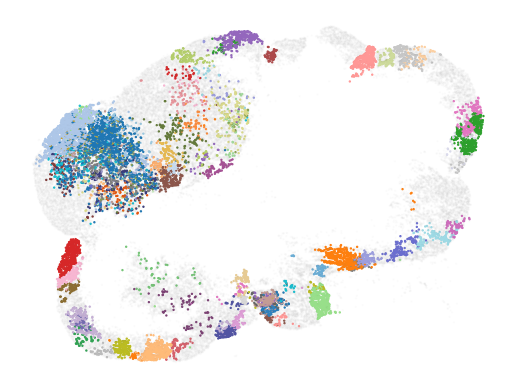

In [18]:
bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)


plt.axis('off')
plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')

In [59]:
adata_genes

AnnData object with n_obs × n_vars = 49625 × 119
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes', 'bc_cluster', 'bc_cluster_n_bcs', 'bc_cluster_found_bcs', 'bc_cluster_bc_names'
    var: 'n_cells'

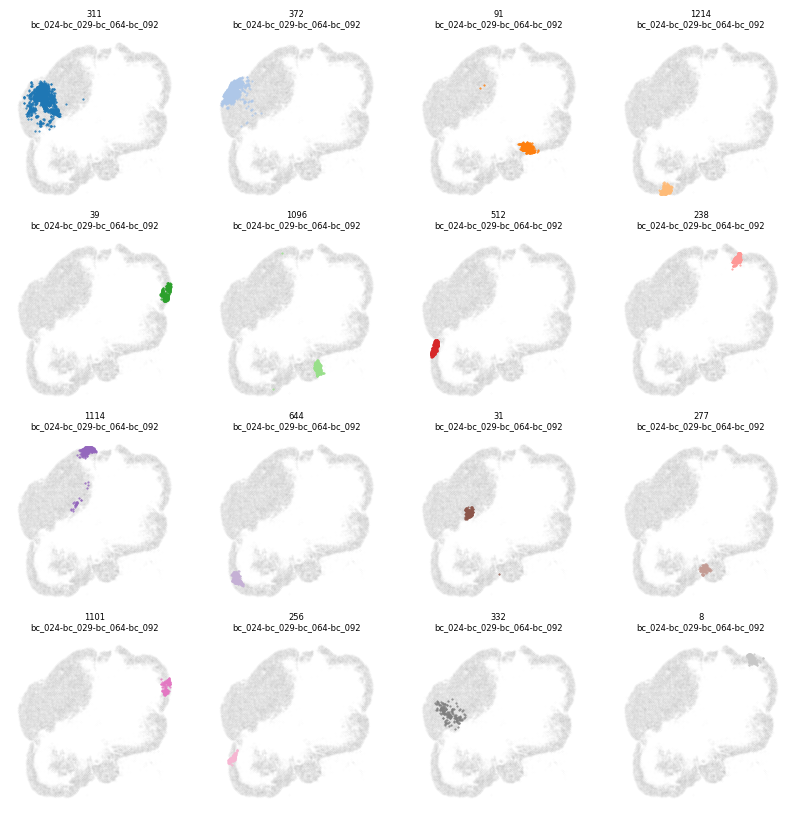

In [63]:
plt.figure(figsize=(10,10))
for i,cluster_name in enumerate(clusters_to_show[:16]):
    
    plt.subplot(4,4,i+1)
    plt.title(f'{cluster_name}\n{cluster_barcode_names[clu]}'
              ,fontsize=6)

    others = adata_genes[adata_genes.obs['bc_cluster']!=cluster_name]
    plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_name]

    plt.scatter(this_cluster.obs['center_x'],this_cluster.obs['center_y'],marker='o',
            color=bc_color_dict[cluster_name],alpha=1.0,
            s=0.25)
    
    plt.axis('off')
    



# bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
# bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

# bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

# plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
#             c=bc_color_list,
#             s=0.5)


# plt.axis('off')
# plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')

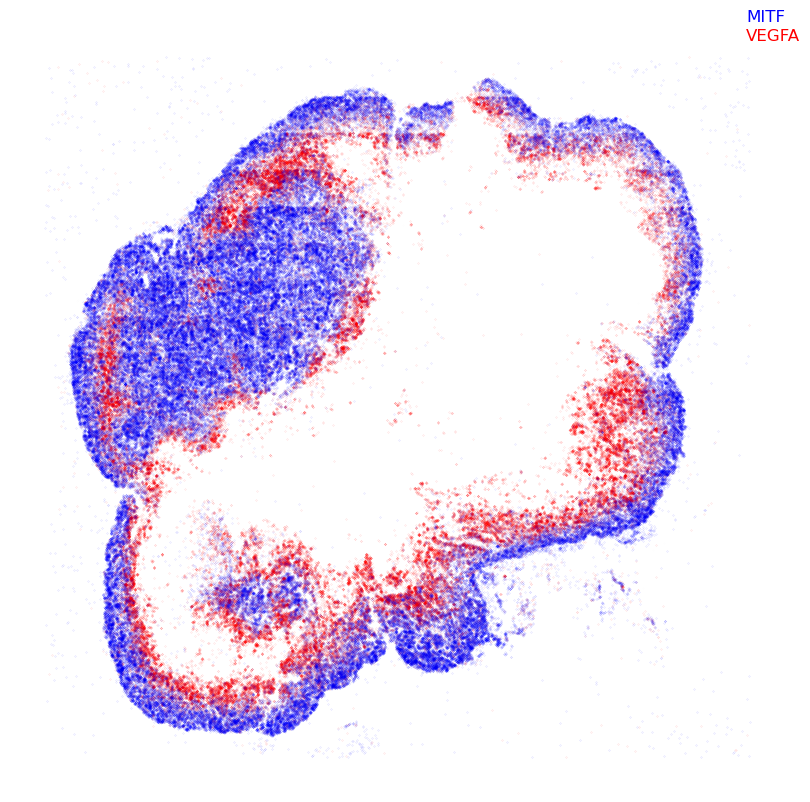

In [90]:
gene_list = ['VEGFA','MITF']
gene_colors = [(1.0,0,0),(0,0,1.0)]

# gene_list = ['VEGFA','COL1A1','MLANA']
# gene_colors = [(1.0,0,0),(0,0,1.0),(0,1,0)]

plt.figure(figsize=(10,10))

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

# this_assigned_points_gdf = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['object_id']]
for gene in gene_list:

    this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene]
    # this_gene_df = 
    
    plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.1,color=gene_colors[gene_list.index(gene)],alpha=0.3)
    
    plt.axis('off')

plt.text(0.95,0.975,'VEGFA',color='red',fontsize=12,ha='left',transform=plt.gca().transAxes)
plt.text(0.95,1.0,'MITF',color='blue',fontsize=12,ha='left',transform=plt.gca().transAxes)

# plt.savefig(f'plots/VEGFA_COL1A1.png',bbox_inches='tight',dpi=300)
plt.savefig(f'plots/VEGFA_MITF.pdf',bbox_inches='tight',dpi=300)


In [27]:
cell_gene_table_df = sg_obj.get_cell_gene_table_df()
cell_gene_table_df['object_id'] = [str(int(x)) for x in cell_gene_table_df['object_id']]

No filtering available or applied.


238
(342, 222)
(49283, 222)


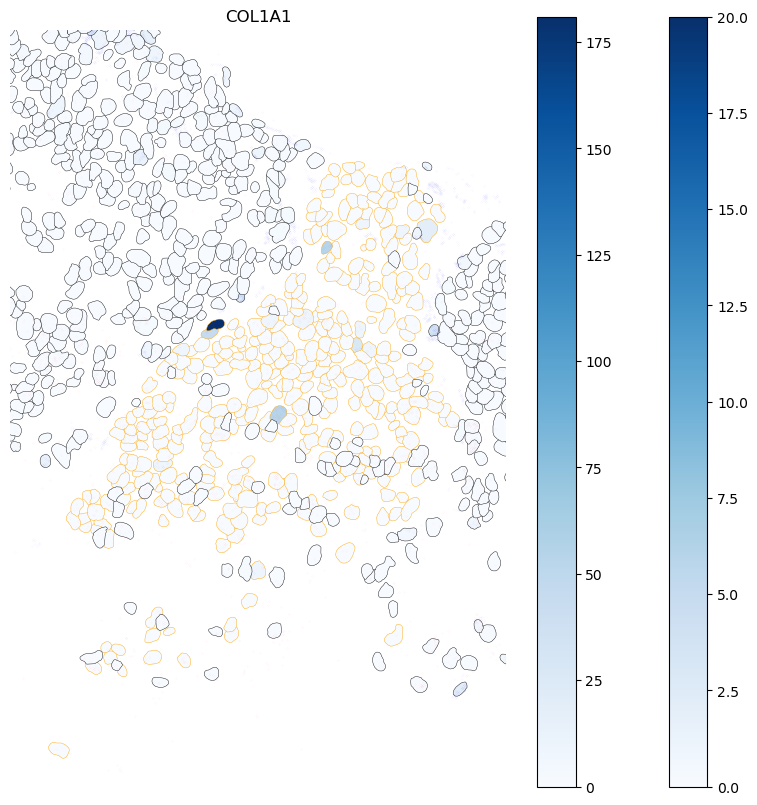

In [37]:
# clusters_of_interest = [311,372]
clusters_of_interest = [238]
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

gene_name = 'VEGFA'
gene_name = 'COL1A1'

gene_list = ['VEGFA','COL1A1']
gene_colors = [(1.0,0,0),(0,0,1.0)]

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,edgecolor='orange',linewidth=0.3)

    # merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,vmin=40,vmax=100,edgecolor='orange',linewidth=0.3)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,edgecolor='k',linewidth=0.3)
# merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=50,vmax=100,edgecolor='k',linewidth=0.05)

ax.set_title(gene_name)
ax.set_aspect('equal')

for gene in gene_list:

    this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene]
    # this_gene_df = 
    
    plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.03,color=gene_colors[gene_list.index(gene)],alpha=0.2)
    
    plt.axis('off')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

plt.xlim(40000,44000)
plt.ylim(39000,45000)


# ax.axis('off')

plt.savefig(f'plots/{roi_name}_{gene_name}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

512
(366, 222)
(49259, 222)


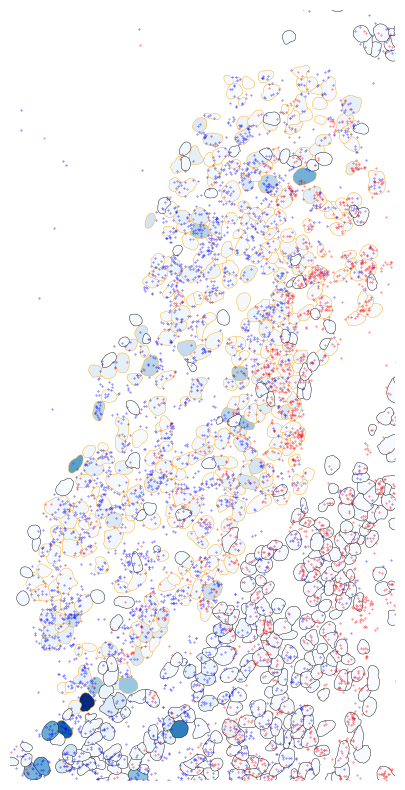

In [137]:
# clusters_of_interest = [311,372]
clusters_of_interest = [238]
clusters_of_interest = [91]
clusters_of_interest = [512]
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

# gene_name = 'VEGFA'
# gene_name = 'COL1A1'

# gene_list = ['VEGFA','COL1A1']
gene_list = ['VEGFA','MITF']
gene_colors = [(1.0,0,0),(0,0,1.0)]

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=False, ax=ax,edgecolor='orange',linewidth=0.3)

    # merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,vmin=40,vmax=100,edgecolor='orange',linewidth=0.3)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=False, ax=ax,edgecolor='k',linewidth=0.3)
# merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=50,vmax=100,edgecolor='k',linewidth=0.05)

for gene in gene_list:

    this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene]
    # this_gene_df = 
    
    plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.5,color=gene_colors[gene_list.index(gene)],alpha=0.7)
    
    # plt.axis('off')

# ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

# plt.xlim(40000,44000)
# plt.ylim(39000,45000)

# plt.xlim(36000,42000)
# plt.ylim(13000,18000)

plt.xlim(5000,8000)
plt.ylim(12500,18500)


ax.axis('off')

plt.savefig(f'plots/{roi_name}_{gene_list}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

372
(1150, 222)
(48475, 222)


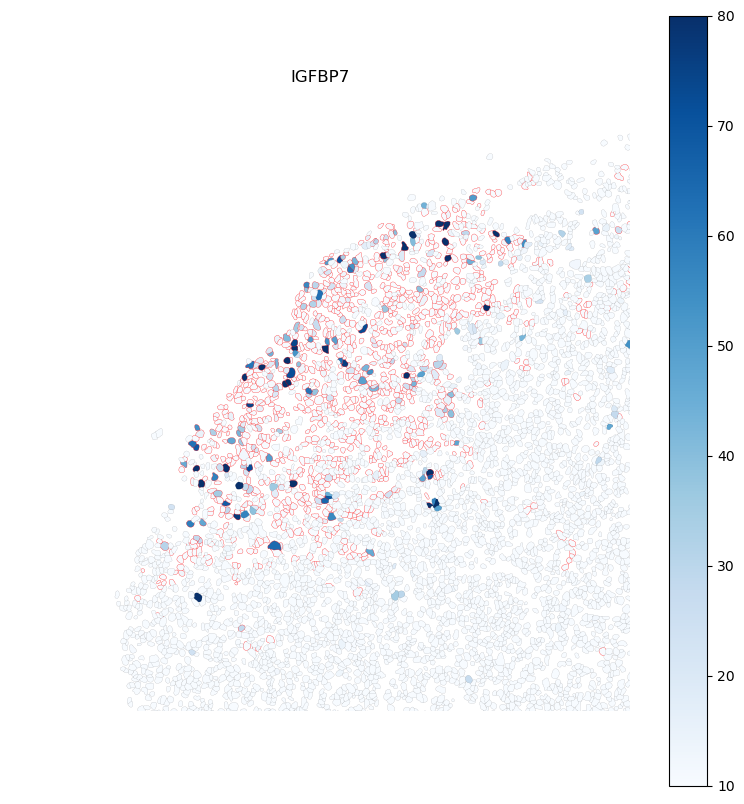

In [214]:
clusters_of_interest = [311,372]
clusters_of_interest = [372]
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

gene_name = 'IGFBP7'

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(column=gene_name, cmap=cmaps[c], legend=True, ax=ax,vmin=10,vmax=80,edgecolor='r',linewidth=0.2)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=10,vmax=80,edgecolor='k',linewidth=0.05)

# for gene in gene_list:

# this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene_name]
    # this_gene_df = 
    
# plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.2,color=gene_colors[gene_list.index(gene)],alpha=0.7)
    
    # plt.axis('off')

ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

plt.xlim(0,12000)
plt.ylim(26000,38000)

ax.axis('off')

plt.savefig(f'plots/{roi_name}_{gene_name}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

In [116]:
cell_ids_high = df[df['IGFBP7'] > 25]['cell_id']

fadata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values

array([1214., 2892.,  258.,  258.,   nan, 1214.,  258., 1214., 1214.,
       1214., 1214.,  258.,  258., 1214., 1214., 1214., 1214., 1214.,
       1214.,  927.,  617., 1214.,  258., 1214., 1214.,  617.,  161.,
        161.,  538.,  538.,  161.,  161.,  161.,  161.,   49.,  175.,
        175.,  175.,  277.,  277.,  277.,  277., 2963.,  277.,  277.,
        564.,  277.,  277.,  564.,  861.,   nan,  277.,  684.,  538.,
        538.,  277., 1589.,  277.,  277.,  277.,  277.,  277.,  641.,
        605.,  256.,  256.,  256.,  256.,  256.,  256.,  256.,  256.,
        256.,  256.,  256.,   nan,  719.,  256.,  512.,  256.,  512.,
        256.,  176.,  512.,  512.,   91.,  512.,  512.,  256.,  512.,
        507.,   nan,  507.,  507.,  237.,  311.,  311., 1330.,  507.,
         nan,  507.,  507.,  507.,  507.,   16.,  845.,  311.,   31.,
        845., 1650.,  273.,  204.,   nan,  100.,  159.,  311.,  741.,
        372.,  109.,  738.,  109.,  196.,   55., 1319.,   72.,  159.,
       1547.,  109.,

In [120]:
np.unique(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values)

array([  16.,   26.,   27.,   31.,   39.,   47.,   49.,   53.,   55.,
         66.,   71.,   72.,   83.,   91.,  100.,  109.,  159.,  161.,
        175.,  176.,  179.,  196.,  204.,  208.,  237.,  256.,  258.,
        273.,  277.,  311.,  325.,  372.,  391.,  403.,  412.,  425.,
        448.,  472.,  500.,  507.,  512.,  538.,  549.,  564.,  605.,
        617.,  641.,  684.,  697.,  719.,  720.,  738.,  741.,  753.,
        756.,  760.,  833.,  845.,  861.,  894.,  927., 1114., 1214.,
       1319., 1330., 1383., 1393., 1443., 1547., 1589., 1650., 1827.,
       1856., 2258., 2892., 2963., 3176.,   nan])

In [156]:
fractions = []
hi_clus = []

hi_clu_dict = {}

clus,counts = np.unique(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values,return_counts=True)
for (bc_clu,hi_count) in zip(clus,counts):
    if ~np.isnan(bc_clu):
        # print(bc_clu)
        all_count = len(adata_genes[adata_genes.obs['bc_cluster']==bc_clu])
        if all_count > 10:
            hi_clus.append(bc_clu)
            fractions.append(hi_count/all_count)
            hi_clu_dict[bc_clu] = hi_count/all_count


In [138]:
all_clus, all_counts = np.unique(adata_genes.obs['bc_cluster'],return_counts = True)

clus_of_interest = []
for clu,count in zip(all_clus,all_counts):
    if count > 5:
        clus_of_interest.append(clu)


In [133]:
big_clus = adata_genes[adata_genes.obs['bc_cluster'].isin(clus_of_interest)]

big_clus[big_clus['']]

fraction_here = len

array([31, 28, 34, 54, 39, 57, 44, 17, 29, 50, 24, 26, 41, 11, 45, 30,  5,
       52, 56,  8, 38, 20, 21, 22, 14, 16, 53, 55, 25, 43, 33, 35, 46, 40,
       42, 47,  6, 58, 36, 51, 37,  4,  0, 48, 13, 18,  1,  7,  2, 32, 27,
       23, 10,  9, 19,  3, 49, 15, 12])

NameError: name 'big_clus' is not defined

In [158]:
hi_clu_dict

{16.0: 0.017241379310344827,
 26.0: 0.014814814814814815,
 27.0: 0.0125,
 31.0: 0.005128205128205128,
 39.0: 0.01871657754010695,
 47.0: 0.07142857142857142,
 49.0: 0.02127659574468085,
 55.0: 0.013157894736842105,
 66.0: 0.05263157894736842,
 71.0: 0.006172839506172839,
 72.0: 0.006211180124223602,
 83.0: 0.07692307692307693,
 91.0: 0.0024096385542168677,
 100.0: 0.016129032258064516,
 109.0: 0.043478260869565216,
 159.0: 0.0030627871362940277,
 161.0: 0.0410958904109589,
 175.0: 0.10714285714285714,
 176.0: 0.015625,
 179.0: 0.005535055350553505,
 196.0: 0.05,
 204.0: 0.045454545454545456,
 208.0: 0.044642857142857144,
 237.0: 0.009174311926605505,
 256.0: 0.08241758241758242,
 258.0: 0.03680981595092025,
 277.0: 0.08021390374331551,
 311.0: 0.009365994236311239,
 325.0: 0.2222222222222222,
 372.0: 0.1,
 391.0: 0.07407407407407407,
 412.0: 0.010752688172043012,
 425.0: 0.03197674418604651,
 448.0: 0.14814814814814814,
 500.0: 0.03180212014134275,
 507.0: 0.019656019656019656,
 512.0:

array([0.00240964, 0.00306279, 0.00343643, 0.00512821, 0.00553506,
       0.00617284, 0.00621118, 0.00917431, 0.00936599, 0.01075269,
       0.0125    , 0.01315789, 0.01481481, 0.015625  , 0.01612903,
       0.01724138, 0.01724138, 0.01871658, 0.01912568, 0.01923077,
       0.01965602, 0.02083333, 0.0212766 , 0.025     , 0.02564103,
       0.02898551, 0.03125   , 0.03180212, 0.03197674, 0.03225806,
       0.03680982, 0.03703704, 0.03856041, 0.04109589, 0.04347826,
       0.04464286, 0.04545455, 0.05      , 0.05263158, 0.05263158,
       0.05882353, 0.06024096, 0.07142857, 0.07407407, 0.0754717 ,
       0.07692308, 0.07692308, 0.0802139 , 0.08241758, 0.09677419,
       0.1       , 0.10714286, 0.14814815, 0.22222222])

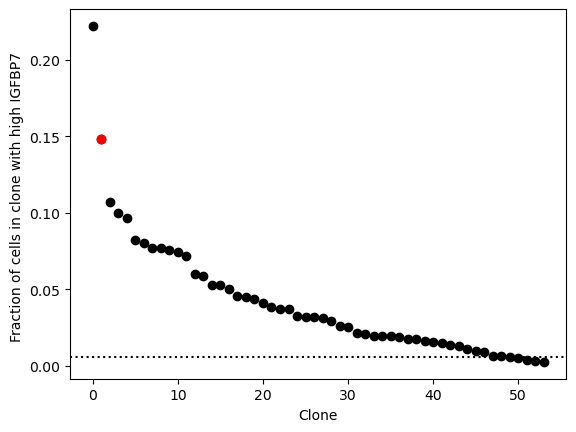

In [177]:
sorted_fractions = sorted

plt.scatter(range(len(fractions)),np.asarray(fractions)[np.argsort(fractions)[::-1]],color='k')
plt.scatter([1],np.asarray(fractions)[np.argsort(fractions)[::-1]][1],color='r')
plt.axhline(len(df[df['IGFBP7']>25].values)/len(df),color='k',linestyle=':')

plt.ylabel('Fraction of cells in clone with high IGFBP7 ')
plt.xlabel('Clone')

plt.savefig('plots/fraction_of_IGFPB7_spots.pdf')

In [117]:
clus,counts = np.unique(adata_genes.obs['bc_cluster'].values,return_counts=True)


cluster_counts = {clu:count for (clu,count) in zip(clus,counts)}

In [118]:
# determine whether IGFBP7 high cells are enriched per clone.

hi_cluster,hi_counts = np.unique(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values,return_counts=True)
all_cluster,all_counts =  np.unique(adata_genes.obs['bc_cluster'].values,return_counts=True)



In [112]:
fractions = []

for clu, all_count in zip(all_cluster,all_counts):
    if clu in hi_cluster:
        if all_count > 10:
            fractions.append(hi_counts[np.where(hi_cluster==clu)[0][0]]/all_count)
    else:
        if all_count > 10:
            fractions.append(0)

In [119]:
all_cluster[np.argsort(fractions)[::-1]]

array([112., 150.,  60., 132., 215.,  90.,  98., 175.,  27., 197., 134.,
        14., 234., 246.,  21., 166.,  69.,  73.,  75.,  40.,  55., 238.,
       245.,  91., 187., 144., 157., 199., 169., 176., 200.,  16., 282.,
       158., 217., 160.,  11., 210.,   3.,  37.,  61.,   6.,  18.,   7.,
       142., 106.,  83.,  24.,  23.,  64.,  10., 212.,  53.,  31.,  89.,
       119., 120.,  94.,  93.,  92., 121., 122., 123.,  84., 124., 128.,
       125., 126., 127.,  87.,  86.,  85.,  88., 107., 110., 100.,  82.,
       111., 105., 104., 103., 102., 113., 101., 114., 109.,  99., 115.,
        97.,  96., 116., 117., 118.,  95., 108.,  67.,  81.,  25.,  41.,
        39.,  38.,  36.,  35.,  34.,  33.,  32.,  30.,  29.,  28.,  26.,
        22.,  43.,  20.,  19.,  17.,  15.,  13.,  12.,   9.,   8.,   5.,
         4.,   2.,   1.,  42.,  44.,  80.,  63.,  79.,  78.,  77.,  76.,
        74.,  72.,  71.,  70.,  68., 130.,  66.,  65.,  62.,  45.,  59.,
        58.,  57.,  56.,  54.,  52.,  51.,  50.,  4

In [114]:
np.argsort(fractions)[::-1]

array([112, 150,  60, 132, 215,  90,  98, 175,  27, 197, 134,  14, 234,
       246,  21, 166,  69,  73,  75,  40,  55, 238, 245,  91, 187, 144,
       157, 199, 169, 176, 200,  16, 282, 158, 217, 160,  11, 210,   3,
        37,  61,   6,  18,   7, 142, 106,  83,  24,  23,  64,  10, 212,
        53,  31,  89, 119, 120,  94,  93,  92, 121, 122, 123,  84, 124,
       128, 125, 126, 127,  87,  86,  85,  88, 107, 110, 100,  82, 111,
       105, 104, 103, 102, 113, 101, 114, 109,  99, 115,  97,  96, 116,
       117, 118,  95, 108,  67,  81,  25,  41,  39,  38,  36,  35,  34,
        33,  32,  30,  29,  28,  26,  22,  43,  20,  19,  17,  15,  13,
        12,   9,   8,   5,   4,   2,   1,  42,  44,  80,  63,  79,  78,
        77,  76,  74,  72,  71,  70,  68, 130,  66,  65,  62,  45,  59,
        58,  57,  56,  54,  52,  51,  50,  49,  48,  47,  46, 129, 285,
       131, 251, 249, 248, 247, 244, 243, 242, 241, 240, 239, 237, 236,
       235, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 22

In [ ]:
plt.scatter()

In [115]:
sorted(fractions)[::-1]

[0.2222222222222222,
 0.14814814814814814,
 0.10714285714285714,
 0.1,
 0.0967741935483871,
 0.08241758241758242,
 0.08021390374331551,
 0.07692307692307693,
 0.07692307692307693,
 0.07547169811320754,
 0.07407407407407407,
 0.07142857142857142,
 0.060240963855421686,
 0.058823529411764705,
 0.05263157894736842,
 0.05263157894736842,
 0.05,
 0.045454545454545456,
 0.044642857142857144,
 0.043478260869565216,
 0.0410958904109589,
 0.038560411311053984,
 0.037037037037037035,
 0.03680981595092025,
 0.03225806451612903,
 0.03197674418604651,
 0.03180212014134275,
 0.03125,
 0.028985507246376812,
 0.02564102564102564,
 0.025,
 0.02127659574468085,
 0.020833333333333332,
 0.019656019656019656,
 0.019230769230769232,
 0.01912568306010929,
 0.01871657754010695,
 0.017241379310344827,
 0.017241379310344827,
 0.016129032258064516,
 0.015625,
 0.014814814814814815,
 0.013157894736842105,
 0.0125,
 0.010752688172043012,
 0.009365994236311239,
 0.009174311926605505,
 0.006211180124223602,
 0.00617

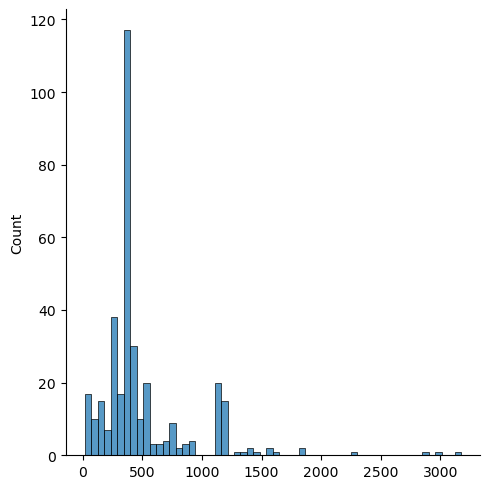

In [82]:
sns.displot(adata_genes[adata_genes.obs['cell_id'].isin(cell_ids_high)].obs['bc_cluster'].values,)

In [80]:
if hi_cluster[]

In [89]:
cluster_counts[372]/np.sum(list(cluster_counts.values()))

0.023173803526448364

In [ ]:
2% of the total clusters have this barcode combination, but 

In [88]:
cluster_counts.values()

dict_values([3, 2, 2, 297, 2, 2, 2, 9, 172, 4, 49, 2, 4, 2, 2, 2, 58, 39, 4, 7, 2, 2, 23, 3, 7, 8, 135, 80, 75, 3, 14, 195, 6, 3, 7, 10, 2, 2, 5, 374, 3, 13, 146, 6, 4, 2, 6, 14, 77, 47, 40, 10, 7, 3, 2, 76, 6, 34, 1, 370, 2, 2, 6, 5, 2, 8, 19, 197, 6, 3, 4, 162, 161, 9, 8, 6, 2, 5, 151, 2, 3, 2, 22, 13, 8, 3, 3, 39, 14, 212, 7, 415, 138, 19, 9, 2, 202, 85, 163, 2, 124, 19, 402, 3, 4, 2, 3, 3, 6, 92, 12, 10, 14, 2, 2, 2, 3, 3, 4, 82, 2, 2, 4, 6, 9, 2, 3, 9, 3, 8, 4, 4, 31, 4, 3, 54, 5, 7, 14, 27, 2, 6, 3, 3, 2, 6, 266, 112, 2, 2, 3, 2, 2, 4, 25, 44, 6, 97, 3, 653, 12, 146, 2, 4, 22, 3, 22, 10, 12, 2, 66, 4, 8, 5, 4, 28, 64, 11, 28, 542, 99, 4, 2, 4, 5, 2, 56, 2, 3, 14, 2, 2, 6, 5, 7, 61, 20, 275, 15, 3, 27, 3, 2, 4, 22, 4, 2, 146, 112, 6, 5, 103, 2, 22, 43, 9, 2, 5, 8, 30, 2, 3, 12, 260, 2, 2, 5, 5, 36, 2, 2, 3, 10, 8, 6, 3, 4, 109, 342, 2, 2, 4, 6, 78, 117, 2, 2, 17, 2, 2, 35, 7, 2, 4, 3, 16, 182, 10, 163, 8, 2, 2, 2, 13, 7, 6, 22, 2, 16, 4, 40, 2, 24, 4, 2, 30, 2, 187, 3, 20, 2, 4, 5

In [83]:
? plt.bar

Signature:
 plt.bar(
    x,
    height,
    width=0.8,
    bottom=None,
    *,
    align='center',
    data=None,
    **kwargs,
)
Docstring:
Make a bar plot.

The bars are positioned at *x* with the given *align*\ment. Their
dimensions are given by *height* and *width*. The vertical baseline
is *bottom* (default 0).

Many parameters can take either a single value applying to all bars
or a sequence of values, one for each bar.

Parameters
----------
x : float or array-like
    The x coordinates of the bars. See also *align* for the
    alignment of the bars to the coordinates.

height : float or array-like
    The height(s) of the bars.

width : float or array-like, default: 0.8
    The width(s) of the bars.

bottom : float or array-like, default: 0
    The y coordinate(s) of the bottom side(s) of the bars.

align : {'center', 'edge'}, default: 'center'
    Alignment of the bars to the *x* coordinates:

    - 'center': Center the base on the *x* positions.
    - 'edge': Align the left e

448
(108, 222)


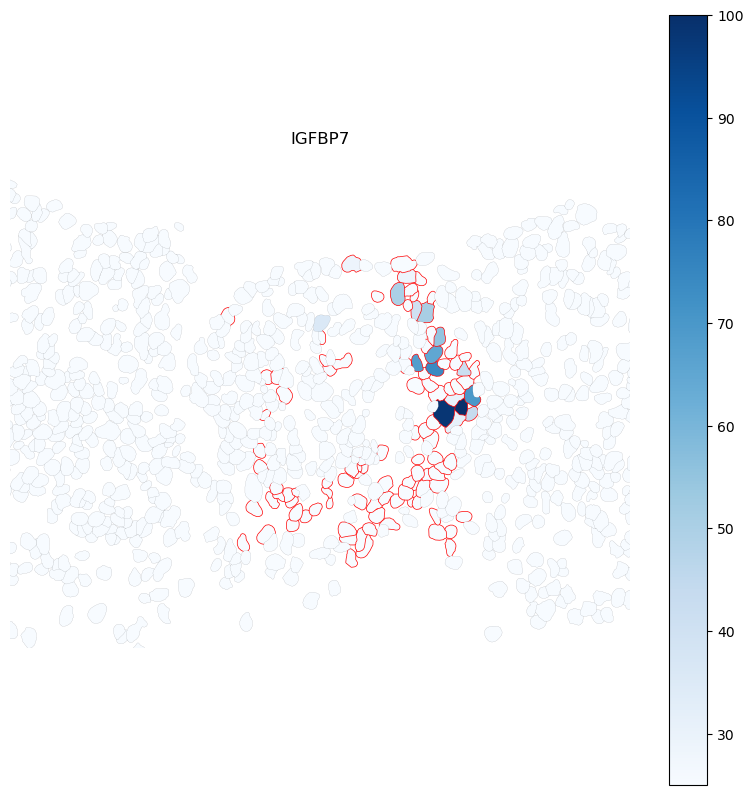

In [170]:
clusters_of_interest = [311,372]
clusters_of_interest = [448,325]
clusters_of_interest = [448]
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

gene_name = 'IGFBP7'

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_of_interest):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(column=gene_name, cmap='Blues', legend=True, ax=ax,vmin=25,vmax=100,edgecolor='r',linewidth=0.5)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

# print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap='Blues', legend=False, ax=ax,vmin=25,vmax=100,edgecolor='k',linewidth=0.05)

# for gene in gene_list:

# this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene_name]
    # this_gene_df = 
    
# plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.2,color=gene_colors[gene_list.index(gene)],alpha=0.7)
    
    # plt.axis('off')

ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

# plt.xlim(42000,52000)
# plt.ylim(40000,45000)

plt.xlim(42000,47000)
plt.ylim(40500,44500)

ax.axis('off')

plt.savefig(f'plots/{roi_name}_{gene_name}_expression_bc_cluster{clusters_of_interest}.png',bbox_inches='tight',dpi=300)

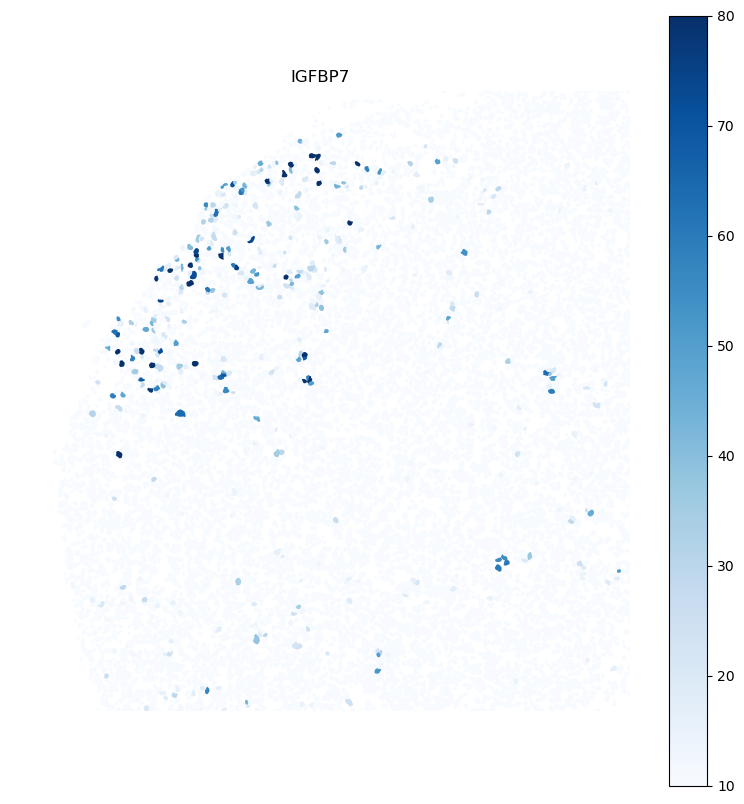

In [210]:
# this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf = sg_obj.gdf.merge(cell_gene_table_df, on='object_id', how='left')

# print(merged_gdf.shape)
merged_gdf.plot(column=gene_name, cmap='Blues', legend=True, ax=ax,vmin=10,vmax=80,edgecolor='None',linewidth=0.05)
ax.set_title(gene_name)
ax.set_aspect('equal')

plt.xlim(1000,16000)
plt.ylim(22000,37000)



ax.axis('off')
plt.savefig('plots/IGFBP7_zoomed.pdf')

In [202]:


triple_bc_clusters = adata_genes.obs[adata_genes.obs['bc_cluster_n_bcs'] >= 3]    

cs,counts = np.unique([int(x) for x in triple_bc_clusters['bc_cluster'].values],return_counts=True)

cs[np.argsort(counts)[::-1]]

array([ 311,  372,   91, 1214,   39, 1096,  512,  238, 1114,  644,   31,
        277, 1101,  256,  332,    8,  258,   71,   72,   78,   42,  161,
         92, 1394,   26,  100,  208,  448,  157,  412,  109,   97,  910,
        746,  617, 1020,  538,   55,  965,   28,  564,  176,  756,  195,
         16, 1534,  186,  753,  927,  356,   10, 3176,   49,  481,  155,
        846, 1510,  511,  431,  228,  250,   57, 1408,  396, 1080,  894,
       1254,  651,  684, 1590,  175, 1383,  335,  632, 1315,  863,  539,
        381,  622,   22,  204,  213,  338,  321, 1511, 1522,  344, 1190,
        196,  279,  331,   93,  527,  318,  339,  329,  325,  599,  247,
        300,  255, 1677,  888,  411,  795,  293,  652, 1692, 1442,  394,
        748,  818,   47, 1666,  620,  112,  567,   83,   41,  783,  605,
        222,  438,  371,  467,  454, 1401, 1072,  446, 1820,  981,  407,
       1228, 1148, 2616,  360, 1112,  319, 1404,  309,  232,  167,  340,
        525, 1646,  551, 1658,  127,  889, 1561,  8

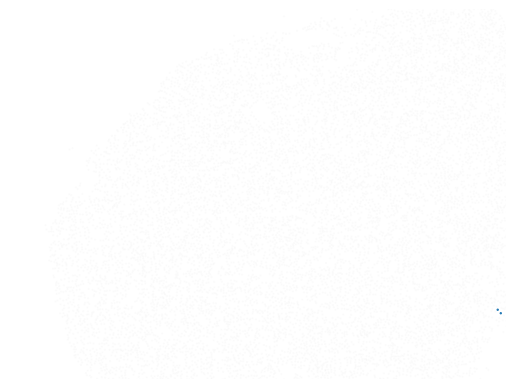

In [203]:
bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)

plt.xlim(1000,16000)
plt.ylim(22000,37000)

plt.axis('off')
plt.savefig(f'plots/{roi_name}_bc_clusters_zoom372.pdf',bbox_inches='tight')

In [205]:
clusters_to_show = []

for clu,count in zip(cs[np.argsort(counts)[::-1]],counts[np.argsort(counts)[::-1]]):
    if count > 20:
        clusters_to_show.append(clu)
        print(clu,count,cluster_n_found_barcodes[clu],cluster_barcode_names[clu])

311 1388 4 bc_001-bc_029-bc_031-bc_087
372 1150 5 bc_029-bc_059-bc_064-bc_068-bc_085
91 415 3 bc_041-bc_066-bc_093
1214 389 4 bc_025-bc_060-bc_062-bc_066
39 374 5 bc_030-bc_058-bc_059-bc_083-bc_095
1096 368 3 bc_009-bc_014-bc_021
512 366 3 bc_028-bc_038-bc_053
238 342 4 bc_019-bc_040-bc_041-bc_052
1114 332 4 bc_041-bc_045-bc_047-bc_052
644 236 4 bc_006-bc_019-bc_064-bc_094
31 195 3 bc_025-bc_079-bc_083
277 187 6 bc_025-bc_039-bc_047-bc_058-bc_076-bc_079
1101 185 3 bc_050-bc_065-bc_089
256 182 4 bc_004-bc_048-bc_066-bc_083
332 177 3 bc_024-bc_048-bc_060
8 172 4 bc_007-bc_013-bc_054-bc_060
258 163 3 bc_001-bc_025-bc_030
71 162 4 bc_021-bc_028-bc_060-bc_067
72 161 3 bc_067-bc_077-bc_087
78 151 3 bc_017-bc_085-bc_087
42 146 3 bc_004-bc_041-bc_077
161 146 4 bc_013-bc_024-bc_082-bc_091
92 138 3 bc_021-bc_058-bc_070
1394 136 3 bc_008-bc_084-bc_086
26 135 6 bc_008-bc_035-bc_059-bc_063-bc_074-bc_081
100 124 4 bc_001-bc_024-bc_031-bc_087
208 112 7 bc_001-bc_003-bc_014-bc_033-bc_060-bc_076-bc_094

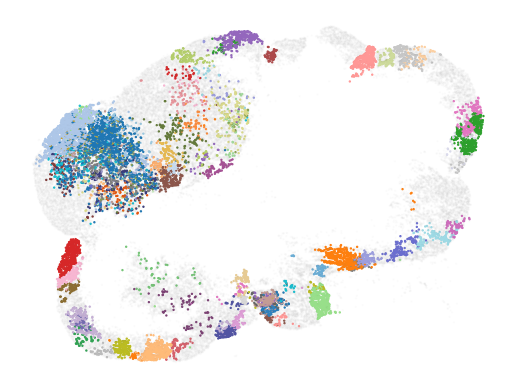

In [206]:
bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)


plt.axis('off')
plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')

311
(1388, 222)
372
(1150, 222)
91
(415, 222)
1214
(389, 222)
39
(374, 222)
1096
(368, 222)
512
(366, 222)
238
(342, 222)
1114
(332, 222)
644
(236, 222)
31
(195, 222)
277
(187, 222)
1101
(185, 222)
256
(182, 222)
332
(177, 222)
8
(172, 222)
258
(163, 222)
71
(162, 222)
72
(161, 222)
78
(151, 222)
42
(146, 222)
161
(146, 222)
92
(138, 222)
1394
(136, 222)
26
(135, 222)
100
(124, 222)
208
(112, 222)
448
(108, 222)
157
(97, 222)
412
(93, 222)
109
(92, 222)
97
(85, 222)
910
(82, 222)
746
(79, 222)
617
(78, 222)
1020
(77, 222)
538
(76, 222)
55
(76, 222)
965
(76, 222)
28
(75, 222)
564
(69, 222)
176
(64, 222)
756
(64, 222)
195
(61, 222)
16
(58, 222)
1534
(57, 222)
186
(56, 222)
753
(53, 222)
927
(52, 222)
356
(50, 222)
10
(49, 222)
3176
(48, 222)
49
(47, 222)
481
(47, 222)
155
(44, 222)
846
(40, 222)
1510
(39, 222)
511
(38, 222)
431
(37, 222)
228
(36, 222)
250
(35, 222)
57
(34, 222)
1408
(31, 222)
396
(31, 222)
1080
(31, 222)
894
(31, 222)
1254
(31, 222)
651
(31, 222)
684
(31, 222)
1590
(29, 

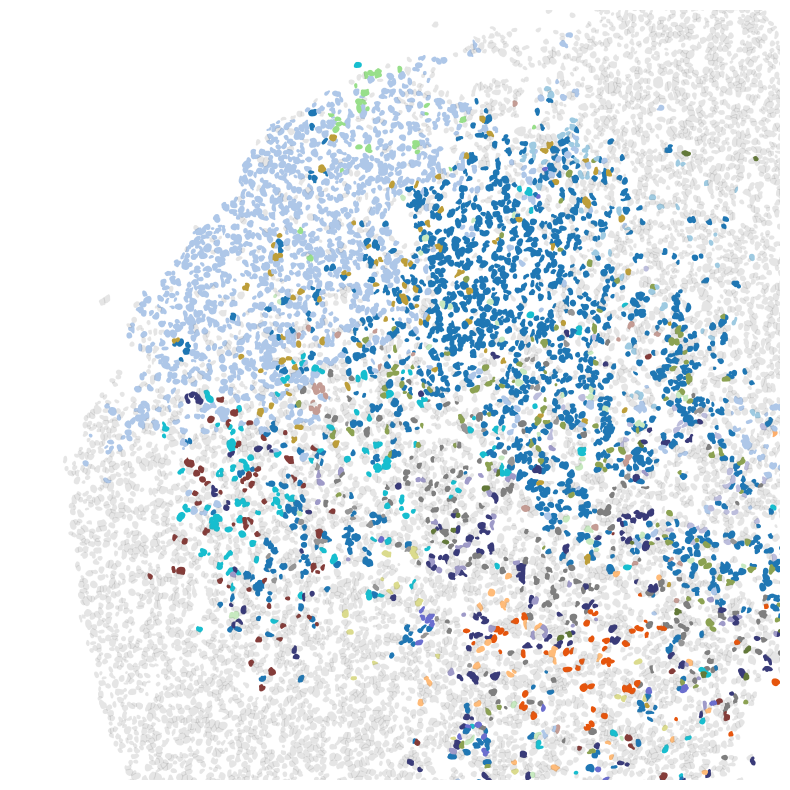

In [209]:
# clusters_of_interest = [311,372]
# clusters_of_interest = [448,325]
# clusters_of_interest = 
# cluster_colors= ['gray','lightgray']
# cluster_colors= ['r','b']
# cmaps = ['Blues','Reds']
# cmaps = ['Reds','Blues']

# gene_name = 'IGFBP7'

fig, ax = plt.subplots(figsize=(10, 10))
for c,cluster in enumerate(clusters_to_show):
    print(cluster)
    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster]

    merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')
    
    print(merged_gdf.shape)
    merged_gdf.plot(color=bc_color_dict[cluster],linewidth=0.5,ax=ax)

this_cluster = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_to_show)]

merged_gdf = sg_obj.gdf[sg_obj.gdf.index.isin(this_cluster.obs.index)].merge(cell_gene_table_df, on='object_id', how='left')

# print(merged_gdf.shape)
merged_gdf.plot(color='gray',linewidth=0.05,ax=ax,alpha=0.2)

# for gene in gene_list:

# this_gene_df = sg_obj.assigned_points_gdf[sg_obj.assigned_points_gdf['name']==gene_name]
    # this_gene_df = 
    
# plt.scatter(this_gene_df['x'],this_gene_df['y'],marker='.',s=0.2,color=gene_colors[gene_list.index(gene)],alpha=0.7)
    
    # plt.axis('off')

# ax.set_title(gene_name)
ax.set_aspect('equal')


# plt.xlim(0,20000)
# plt.ylim(20000,38000)

# plt.xlim(42000,52000)
# plt.ylim(40000,45000)

# plt.xlim(42000,47000)
# plt.ylim(40500,44500)


plt.xlim(1000,16000)
plt.ylim(22000,37000)

ax.axis('off')

plt.savefig(f'plots/zoomed_clusters.png',bbox_inches='tight',dpi=300)